In [1]:
# importing dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

In [2]:
# reading in data and dropping useless columns
ratings = pd.read_csv('data/ratings.csv')

ratings.drop(columns='timestamp', axis=1, inplace=True)

In [3]:
# displaying dataframe
ratings.head()

,userId,movieId,rating
0,1,110,1.0
1,1,147,4.5
2,1,858,5.0
3,1,1221,5.0
4,1,1246,5.0


In [4]:
# reading in movies_metadata.csv
movies = pd.read_csv('data/movies_metadata.csv')

# renaming id column to movieId to match other df
movies.rename(columns=({'id':'movieId'}), inplace=True)

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
import json

# deconstructing list of dictionaries to get only the values (genres)
movies['genres'] = movies['genres'].str.replace("'", '"').apply(lambda x: ','.join([_["name"] for _ in json.loads(x)]))

In [6]:
# only taking the genres, movieId, and title columns
movies = movies[['genres', 'movieId', 'title']]
movies.genres = movies.genres.str.split(',')

In [7]:
# splitting genres into columns

In [8]:
genres = pd.DataFrame(movies['genres'].tolist(), index=movies.index)
genres['movieId'] = movies['movieId']
genres['title'] = movies['title']

genres.fillna("", inplace=True)

In [9]:
genres.rename(columns={
    0:'genre_1',
    1:'genre_2',
    2:'genre_3',
    3:'genre_4',
    4:'genre_5',
    5:'genre_6',
    6:'genre_7',
    7:'genre_8'
}, inplace=True)

In [10]:
genres = genres[['movieId', 'title', 'genre_1', 'genre_2', 'genre_3', 'genre_4', 'genre_5', 'genre_6', 'genre_7', 'genre_8']]

genres.head()

,movieId,title,genre_1,genre_2,genre_3,genre_4,genre_5,genre_6,genre_7,genre_8
0,862,Toy Story,Animation,Comedy,Family,,,,,
1,8844,Jumanji,Adventure,Fantasy,Family,,,,,
2,15602,Grumpier Old Men,Romance,Comedy,,,,,,
3,31357,Waiting to Exhale,Comedy,Drama,Romance,,,,,
4,11862,Father of the Bride Part II,Comedy,,,,,,,


In [11]:
joined = ratings.join(genres[['title','genre_1', 'genre_2', 'genre_3', 'genre_4', 'genre_5', 'genre_6', 'genre_7', 'genre_8']], on='movieId')

In [12]:
# getting number of ratings per movie
rating_count = joined.groupby('movieId').count()

# geting the average rating for each movie
avg_ratings = joined.groupby('movieId').mean()['rating']

# making sure the df has only movies with greater than 30 ratings
avg_ratings = avg_ratings.loc[rating_count['rating'] > 30]

# sorting df by descending order
sorted = avg_ratings.sort_values(ascending=False)

# putting sorted into df
sort_df = pd.DataFrame(sorted)

# resetting index
sort_df = sort_df.reset_index(level=0)

# renaming and adding the avg rating column to df
sort_df['avg_rating'] = sort_df['rating']

# dropping rating column
sort_df.drop(columns='rating', inplace=True)

# display df
sort_df.head()

,movieId,avg_rating
0,142115,4.439655
1,159817,4.437888
2,318,4.422855
3,170705,4.389831
4,166024,4.369048


In [13]:
# average rating for each movie df
data = sort_df.join(ratings['userId'], on='movieId')

dat_new = data.join(genres[['genre_1', 'genre_2', 'genre_3', 'genre_4', 'genre_5', 'genre_6', 'genre_7', 'genre_8']], on='movieId')

dat_new = dat_new[['userId', 'movieId', 'avg_rating', 'genre_1', 'genre_2', 'genre_3', 'genre_4', 'genre_5', 'genre_6', 'genre_7', 'genre_8']]

final = dat_new.drop(['genre_2', 'genre_3', 'genre_4', 'genre_5', 'genre_6', 'genre_7', 'genre_8'], axis=1).fillna("")

In [14]:
final['userId'].drop_duplicates(inplace=True)

In [15]:
db_scan_dat = dat_new.reset_index().set_index('userId').pivot(columns='movieId', values='avg_rating').fillna(0)

melt = final.reset_index().pivot_table(values='avg_rating', index='userId', columns='genre_1')

melt.fillna(0, inplace=True)
melt

genre_1,,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,...,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
userId,,,,,,,,,,,,,,,,,,,,,
1,0.000000,3.157254,3.437604,0.0,3.356774,3.675786,0.000000,3.347356,2.684727,0.000000,...,3.405440,0.000000,0.000000,0.0,3.213511,0.000000,0.0,0.000000,0.0,0.0
2,0.000000,3.668784,4.009499,0.0,2.975862,3.271533,0.000000,3.418612,0.000000,3.317826,...,3.624052,0.000000,0.000000,0.0,3.895335,3.203018,0.0,0.000000,0.0,0.0
3,3.139706,4.029512,0.000000,0.0,3.299250,0.000000,0.000000,3.317466,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,3.977672,0.0,0.0
4,3.587121,3.123182,3.502942,0.0,3.134425,3.429387,3.587117,3.297439,3.156018,0.000000,...,0.000000,3.009877,3.386578,0.0,3.989002,0.000000,0.0,0.000000,0.0,0.0
5,2.847349,0.000000,0.000000,0.0,3.452213,2.903571,0.000000,3.351343,0.000000,3.421053,...,0.000000,0.000000,2.754149,0.0,3.226701,0.000000,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1787,4.389831,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0
1788,3.118644,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0
1799,3.967105,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0


In [16]:
db_cluster = DBSCAN(eps=9.7, min_samples=2, algorithm='ball_tree', metric='minkowski', leaf_size=90, p=2)
arr = db_cluster.fit_predict(db_scan_dat)
print("Clusters assigned are:", set(db_cluster.labels_))

uni, counts = np.unique(arr, return_counts=True)
d = dict(zip(uni, counts))
print(d)

Clusters assigned are: {0, -1}
{-1: 195, 0: 536}


In [23]:
X = melt.drop('Action', axis=1)
y = melt['Action']

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=15)

In [25]:
scaler = StandardScaler()

X_scaler = scaler.fit(X_train)

X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

X_train_scaled

array([[ 0.50986131, -0.32437917, -0.2898289 , ..., -0.32907714,
        -0.20131881, -0.21646696],
       [ 0.51856939, -0.32437917, -0.2898289 , ..., -0.32907714,
        -0.20131881, -0.21646696],
       [ 0.63633687,  3.03060708,  3.57100088, ...,  3.05401077,
        -0.20131881, -0.21646696],
       ...,
       [ 0.62696597, -0.32437917, -0.2898289 , ..., -0.32907714,
        -0.20131881, -0.21646696],
       [ 0.59159171, -0.32437917, -0.2898289 , ..., -0.32907714,
        -0.20131881, -0.21646696],
       [ 0.6386089 , -0.32437917, -0.2898289 , ..., -0.32907714,
        -0.20131881, -0.21646696]])

In [43]:
# MODEL TO PREDICT THE SCORE OF A MOVIE IN A CERTAIN GENRE (COMEDY)

num_input = 20
hl1 = 100
hl2 = 50
hl3 = 25

nn = tf.keras.models.Sequential()

nn.add(tf.keras.layers.Dense(units=hl1, input_dim = num_input, activation='relu'))

nn.add(tf.keras.layers.Dense(units=hl2, activation='relu'))

nn.add(tf.keras.layers.Dense(units=hl3, activation='relu'))

nn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

nn.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 100)               2100      
                                                                 
 dense_17 (Dense)            (None, 50)                5050      
                                                                 
 dense_18 (Dense)            (None, 25)                1275      
                                                                 
 dense_19 (Dense)            (None, 1)                 26        
                                                                 
Total params: 8,451
Trainable params: 8,451
Non-trainable params: 0
_________________________________________________________________


In [44]:
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy", "mse"])

In [45]:
fit_model = nn.fit(X_train_scaled, y_train,epochs=100)

Epoch 1/100
18/18 [==============================] - 2s 4ms/step - loss: 0.1982 - accuracy: 0.6861 - mse: 1.3166
Epoch 2/100
18/18 [==============================] - 0s 5ms/step - loss: -1.4338 - accuracy: 0.7518 - mse: 1.0494
Epoch 3/100
18/18 [==============================] - 0s 4ms/step - loss: -5.0431 - accuracy: 0.7518 - mse: 0.9974
Epoch 4/100
18/18 [==============================] - 0s 4ms/step - loss: -14.0073 - accuracy: 0.7500 - mse: 0.9919
Epoch 5/100
18/18 [==============================] - 0s 3ms/step - loss: -37.3808 - accuracy: 0.7500 - mse: 0.9912
Epoch 6/100
18/18 [==============================] - 0s 4ms/step - loss: -87.1066 - accuracy: 0.7500 - mse: 0.9910
Epoch 7/100
18/18 [==============================] - 0s 4ms/step - loss: -191.0353 - accuracy: 0.7500 - mse: 0.9909
Epoch 8/100
18/18 [==============================] - 0s 3ms/step - loss: -365.8039 - accuracy: 0.7500 - mse: 0.9908
Epoch 9/100
18/18 [==============================] - 0s 4ms/step - loss: -691.0490

<AxesSubplot:>

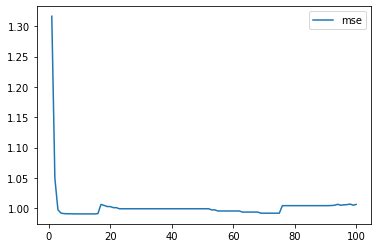

In [46]:
pd.DataFrame(fit_model.history, index=range(1,len(fit_model.history["loss"])+1)).plot(y="mse")

In [47]:
model_loss, model_accuracy, mean_squared_error = nn.evaluate(X_test_scaled,y_test,verbose=2)

print(f"Loss: {model_loss}, Accuracy: {model_accuracy}, MSE: {mean_squared_error}")

6/6 - 0s - loss: -1.8839e+07 - accuracy: 0.8033 - mse: 0.7400 - 221ms/epoch - 37ms/step
Loss: -18838902.0, Accuracy: 0.8032786846160889, MSE: 0.7399502396583557


In [34]:
# MODEL TO PREDICT THE AVERAGE RATING OF A SPECIFIC MOVIE (MOVIEID 1)

b = db_scan_dat.drop(1, axis=1)
g = db_scan_dat[1]

b_train, b_test, g_train, g_test = train_test_split(b, g, random_state=15)

b_train_scaled = scaler.fit_transform(b_train)
b_test_scaled = scaler.fit_transform(b_test)



num_input = 8884
hl1 = 200
hl2 = 100
hl3 = 50

mId = tf.keras.models.Sequential()

mId.add(tf.keras.layers.Dense(units=hl1, input_dim = num_input, activation='relu'))

mId.add(tf.keras.layers.Dense(units=hl2, activation='relu'))

mId.add(tf.keras.layers.Dense(units=hl3, activation='relu'))

mId.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

mId.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 200)               1777000   
                                                                 
 dense_9 (Dense)             (None, 100)               20100     
                                                                 
 dense_10 (Dense)            (None, 50)                5050      
                                                                 
 dense_11 (Dense)            (None, 1)                 51        
                                                                 
Total params: 1,802,201
Trainable params: 1,802,201
Non-trainable params: 0
_________________________________________________________________


In [35]:
mId.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy", "mse"])

In [36]:
model = mId.fit(b_train_scaled, g_train,epochs=100)

Epoch 1/100
18/18 [==============================] - 2s 26ms/step - loss: 0.6474 - accuracy: 0.9197 - mse: 0.0977
Epoch 2/100
18/18 [==============================] - 1s 29ms/step - loss: 0.0409 - accuracy: 0.9982 - mse: 0.0275
Epoch 3/100
18/18 [==============================] - 0s 27ms/step - loss: 0.0234 - accuracy: 0.9982 - mse: 0.0270
Epoch 4/100
18/18 [==============================] - 0s 27ms/step - loss: 0.0139 - accuracy: 0.9982 - mse: 0.0258
Epoch 5/100
18/18 [==============================] - 0s 26ms/step - loss: 0.0078 - accuracy: 0.9982 - mse: 0.0239
Epoch 6/100
18/18 [==============================] - 1s 29ms/step - loss: -0.0016 - accuracy: 0.9982 - mse: 0.0195
Epoch 7/100
18/18 [==============================] - 0s 27ms/step - loss: -0.0133 - accuracy: 0.9982 - mse: 0.0160
Epoch 8/100
18/18 [==============================] - 0s 26ms/step - loss: -0.0235 - accuracy: 0.9982 - mse: 0.0153
Epoch 9/100
18/18 [==============================] - 0s 27ms/step - loss: -0.0364 - a

In [37]:
loss, accuracy, mse = mId.evaluate(b_test_scaled,g_test,verbose=2)

print(f"Loss: {loss}, Accuracy: {accuracy}, MSE: {mse}")

6/6 - 0s - loss: 0.6526 - accuracy: 0.9891 - mse: 0.0093 - 243ms/epoch - 40ms/step
Loss: 0.6525976657867432, Accuracy: 0.9890710115432739, MSE: 0.0093009602278471
